# Submission 2: Denoising Autoencoders
Trains CNN autoencoders to denoise pneumonia images based on [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf). Contains 3 CNN autoencoders:
1. Autoencoder for denoising noisy images with lambda = 25
2. Autoencoder for denoising noisy images with lambda = 50
3. Autoencoder for denoising noisy images with lambda = 75

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import pandas as pd
from io import StringIO
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from PIL import Image
import torch
import cv2
import numpy as np
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
originalDatasetPath = r"datasets/pneumonia"
originalDatasetFilenames = os.listdir(originalDatasetPath)
originalDatasetIndices = np.arange(0, len(originalDatasetFilenames))

In [3]:
# Clean Dataset Class

class CleanDataset(Dataset):
    def __init__(self, imgDir, filenames):
        self.img_dir = imgDir
        self.img_labels = pd.DataFrame(filenames, columns=['filename'])
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
            transforms.ToTensor(),  # Convert images to PyTorch tensors
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read image
        image = Image.open(img_path).convert('L')  
        
        image = self.preprocessing(image)
        label = self.imgLabels.iloc[idx]
        
        return image, label

In [4]:
# Add Noise Function

def addPoisson(img, lambdaVal):
    poissonNoise = np.random.poisson(lambdaVal, size=img.shape)
    noisyImage = img + poissonNoise
    if noisyImage.dtype != np.uint8:
        noisyImage = cv2.convertScaleAbs(noisyImage)
    return noisyImage

# Noisy Dataset Class

class NoisyDataset(Dataset):
    def __init__(self, imgDir, filenames, lambdaVal):
        self.imgDir = imgDir
        self.lambdaVal = lambdaVal
        self.imgLabels = pd.DataFrame([filename for filename in filenames])
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
            transforms.ToTensor(),  # Convert images to PyTorch tensors
        ])

    def __len__(self):
        return len(self.imgLabels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.imgLabels.iloc[idx, 0]
        imgPath = self.imgDir + "/" + filename
        label = self.imgLabels.iloc[idx]
        
        # Read image and label/filename
        image = cv2.imread(imgPath, 0)
        cleanImage = Image.fromarray(image)
        cleanImage = self.preprocessing(cleanImage)
        noisyImage = addPoisson(image, self.lambdaVal)
        noisyImage = Image.fromarray(noisyImage)
        noisyImage = self.preprocessing(noisyImage)
       
        return noisyImage, cleanImage

In [5]:
# Get indices to split data into 80% training and 20% test data
trainIndices, testIndices = train_test_split(originalDatasetFilenames, train_size=0.8, random_state=0)

print(f"Training samples: {len(trainIndices)} ({len(trainIndices)/len(originalDatasetIndices)*100}% of data)")
print(f"Test samples: {len(testIndices)} ({len(testIndices)/len(originalDatasetIndices)*100}% of data)")

Training samples: 1850 (79.98270644185041% of data)
Test samples: 463 (20.01729355814959% of data)


In [6]:
trainCleanDataset = CleanDataset(imgDir=originalDatasetPath, filenames=trainIndices)
testCleanDataset = CleanDataset(imgDir=originalDatasetPath, filenames=testIndices)

trainNoisyDataset25 = NoisyDataset(imgDir=originalDatasetPath, filenames=trainIndices, lambdaVal = 25)
trainNoisyDataset50 = NoisyDataset(imgDir=originalDatasetPath, filenames=trainIndices, lambdaVal = 50)
trainNoisyDataset75 = NoisyDataset(imgDir=originalDatasetPath, filenames=trainIndices, lambdaVal = 75)
testNoisyDataset25 = NoisyDataset(imgDir=originalDatasetPath, filenames=testIndices, lambdaVal = 25)
testNoisyDataset50 = NoisyDataset(imgDir=originalDatasetPath, filenames=testIndices, lambdaVal = 50)
testNoisyDataset75 = NoisyDataset(imgDir=originalDatasetPath, filenames=testIndices, lambdaVal = 75)

## CNN Autoencoders

In [7]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),  
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()  
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Train Model Func
def trainModel(model, dataloader, criterion, optimizer, numEpochs=100):
    for epoch in range(numEpochs):
        model.train() 
        
        runningLoss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            runningLoss += loss.item() * inputs.size(0)
        
        epochLoss = runningLoss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{numEpochs}, Loss: {epochLoss:.4f}')

In [9]:
# Dataloaders

batchSize = 64

trainLoader25 = DataLoader(trainNoisyDataset25, batch_size=batchSize, shuffle=True)
trainLoader50 = DataLoader(trainNoisyDataset50, batch_size=batchSize, shuffle=True)
trainLoader75 = DataLoader(trainNoisyDataset75, batch_size=batchSize, shuffle=True)

testLoader25 = DataLoader(testNoisyDataset25, batch_size=batchSize, shuffle=False)
testLoader50 = DataLoader(testNoisyDataset50, batch_size=batchSize, shuffle=False)
testLoader75 = DataLoader(testNoisyDataset75, batch_size=batchSize, shuffle=False)

In [10]:
# Train Model
from torch.utils.data import DataLoader

# Example for one set, repeat for each noise level dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

model25 = CNNAutoencoder().to(device)
optimizer25 = optim.Adam(model25.parameters(), lr=0.001)

model50 = CNNAutoencoder().to(device)
optimizer50 = optim.Adam(model50.parameters(), lr=0.001)

model75 = CNNAutoencoder().to(device)
optimizer75 = optim.Adam(model75.parameters(), lr=0.001)

# Train each model
trainModel(model25, trainLoader25, criterion, optimizer25, numEpochs=25)
trainModel(model50, trainLoader50, criterion, optimizer50, numEpochs=25)
trainModel(model75, trainLoader75, criterion, optimizer75, numEpochs=25)

Epoch 1/25, Loss: 0.0297
Epoch 2/25, Loss: 0.0066
Epoch 3/25, Loss: 0.0038
Epoch 4/25, Loss: 0.0031
Epoch 5/25, Loss: 0.0024
Epoch 6/25, Loss: 0.0036
Epoch 7/25, Loss: 0.0023
Epoch 8/25, Loss: 0.0019
Epoch 9/25, Loss: 0.0018
Epoch 10/25, Loss: 0.0017
Epoch 11/25, Loss: 0.0017
Epoch 12/25, Loss: 0.0016
Epoch 13/25, Loss: 0.0016
Epoch 14/25, Loss: 0.0015
Epoch 15/25, Loss: 0.0016
Epoch 16/25, Loss: 0.0014
Epoch 17/25, Loss: 0.0014
Epoch 18/25, Loss: 0.0014
Epoch 19/25, Loss: 0.0013
Epoch 20/25, Loss: 0.0014
Epoch 21/25, Loss: 0.0012
Epoch 22/25, Loss: 0.0012
Epoch 23/25, Loss: 0.0012
Epoch 24/25, Loss: 0.0014
Epoch 25/25, Loss: 0.0012
Epoch 1/25, Loss: 0.0294
Epoch 2/25, Loss: 0.0059
Epoch 3/25, Loss: 0.0036
Epoch 4/25, Loss: 0.0029
Epoch 5/25, Loss: 0.0031
Epoch 6/25, Loss: 0.0023
Epoch 7/25, Loss: 0.0021
Epoch 8/25, Loss: 0.0019
Epoch 9/25, Loss: 0.0018
Epoch 10/25, Loss: 0.0018
Epoch 11/25, Loss: 0.0017
Epoch 12/25, Loss: 0.0017
Epoch 13/25, Loss: 0.0016
Epoch 14/25, Loss: 0.0015
Epoc

In [13]:
# Display Image Function for Eval. Displays 10 images

def displayImages(noisyImgs, cleanImgs, reconstructedImgs):
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))  
    for i in range(10):  
        ax = axes[0, i]
        ax.imshow(noisyImgs[i].squeeze(), cmap='gray')
        ax.set_title(f"Noisy {i+1}")
        ax.axis('off')
        
        ax = axes[1, i]
        ax.imshow(cleanImgs[i].squeeze(), cmap='gray')
        ax.set_title(f"Clean {i+1}")
        ax.axis('off')
        
        ax = axes[2, i]
        ax.imshow(reconstructedImgs[i].squeeze(), cmap='gray')
        ax.set_title(f"Reconstructed {i+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
def evaluateModel(model, dataLoader):
    model.eval()  
    totalMSE = 0.0
    totalSSIM = 0.0
    totalPSNR = 0.0
    
    noisyImgsToDisplay = []
    cleanImgsToDisplay = []
    reconstructedImgsToDisplay = []
    
    with torch.no_grad(): 
        for noisyImgs, cleanImgs in dataLoader:
            noisyImgs, cleanImgs = noisyImgs.to(device), cleanImgs.to(device)
            outputs = model(noisyImgs)

            # Compute metrics for all images
            for output, cleanImg in zip(outputs, cleanImgs):
                outputNP = output.squeeze().cpu().numpy()
                cleanImgNP = cleanImg.squeeze().cpu().numpy()
                mse = np.mean((outputNP - cleanImgNP) ** 2)
                totalMSE += mse * noisyImgs.size(0)
                totalSSIM += SSIM(outputNP, cleanImgNP, data_range=outputNP.max() - outputNP.min())
                totalPSNR += PSNR(cleanImgNP, outputNP, data_range=cleanImgNP.max() - cleanImgNP.min())
            
            if len(noisyImgsToDisplay) < 10:
                batchSize = noisyImgs.size(0)
                needed = 10 - len(noisyImgsToDisplay)
                take = min(batchSize, needed)
                
                noisyImgsToDisplay.extend(noisyImgs[:take].cpu().numpy())
                cleanImgsToDisplay.extend(cleanImgs[:take].cpu().numpy())
                reconstructedImgsToDisplay.extend(outputs[:take].cpu().numpy())

    avgMSE = totalMSE / len(dataLoader.dataset)
    avgSSIM = totalSSIM / len(dataLoader.dataset)
    avgPSNR = totalPSNR / len(dataLoader.dataset)
    print(f'Average MSE: {avgMSE}, Average SSIM: {avgSSIM}, Average PSNR: {avgPSNR}')
    
    displayImages(noisyImgsToDisplay, cleanImgsToDisplay, reconstructedImgsToDisplay)

Average MSE: 0.0730291191197089, Average SSIM: 0.8791872255735971, Average PSNR: 27.844075905695345


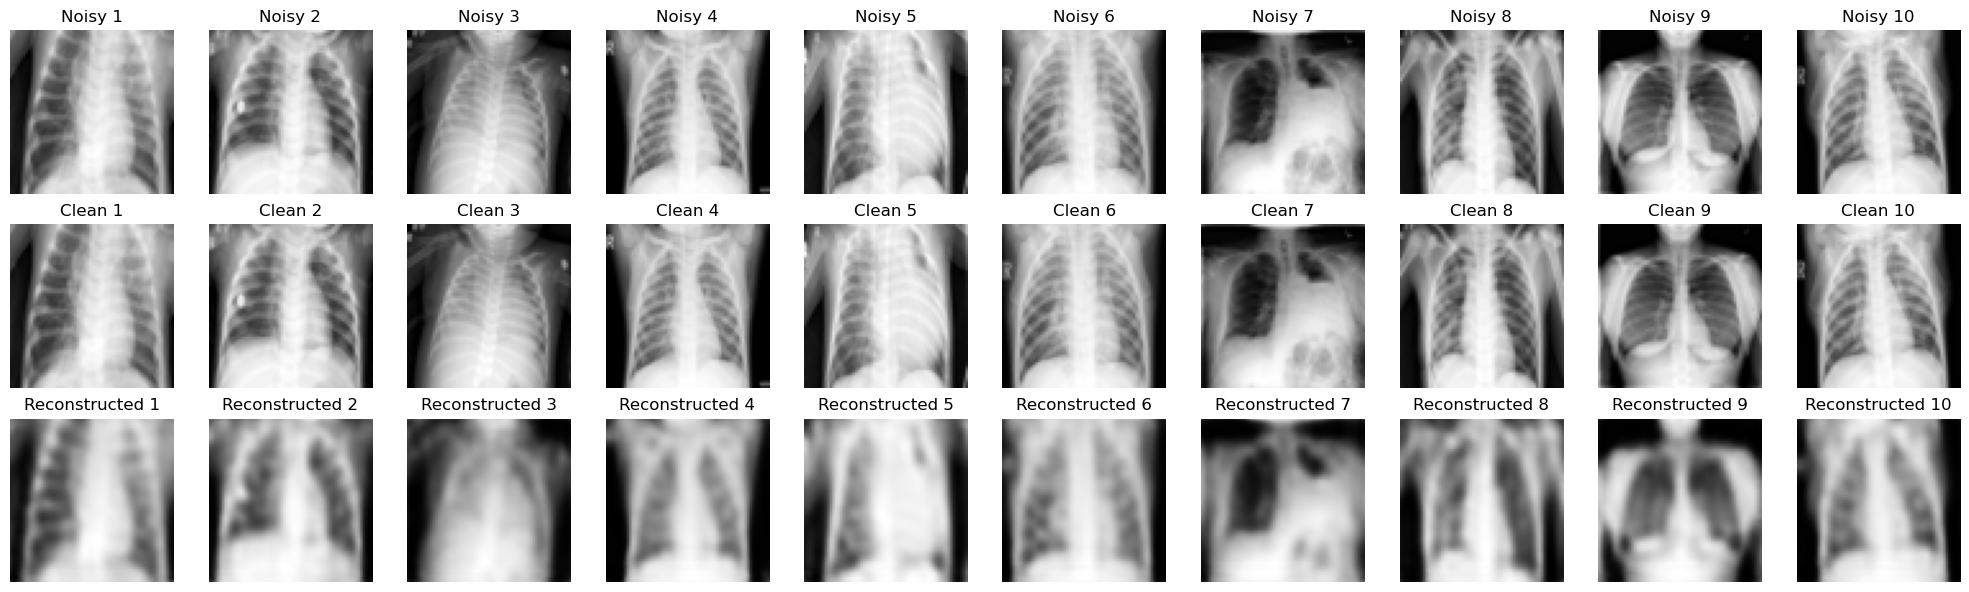

Average MSE: 0.07525434515852085, Average SSIM: 0.8759005265334304, Average PSNR: 27.70823661947168


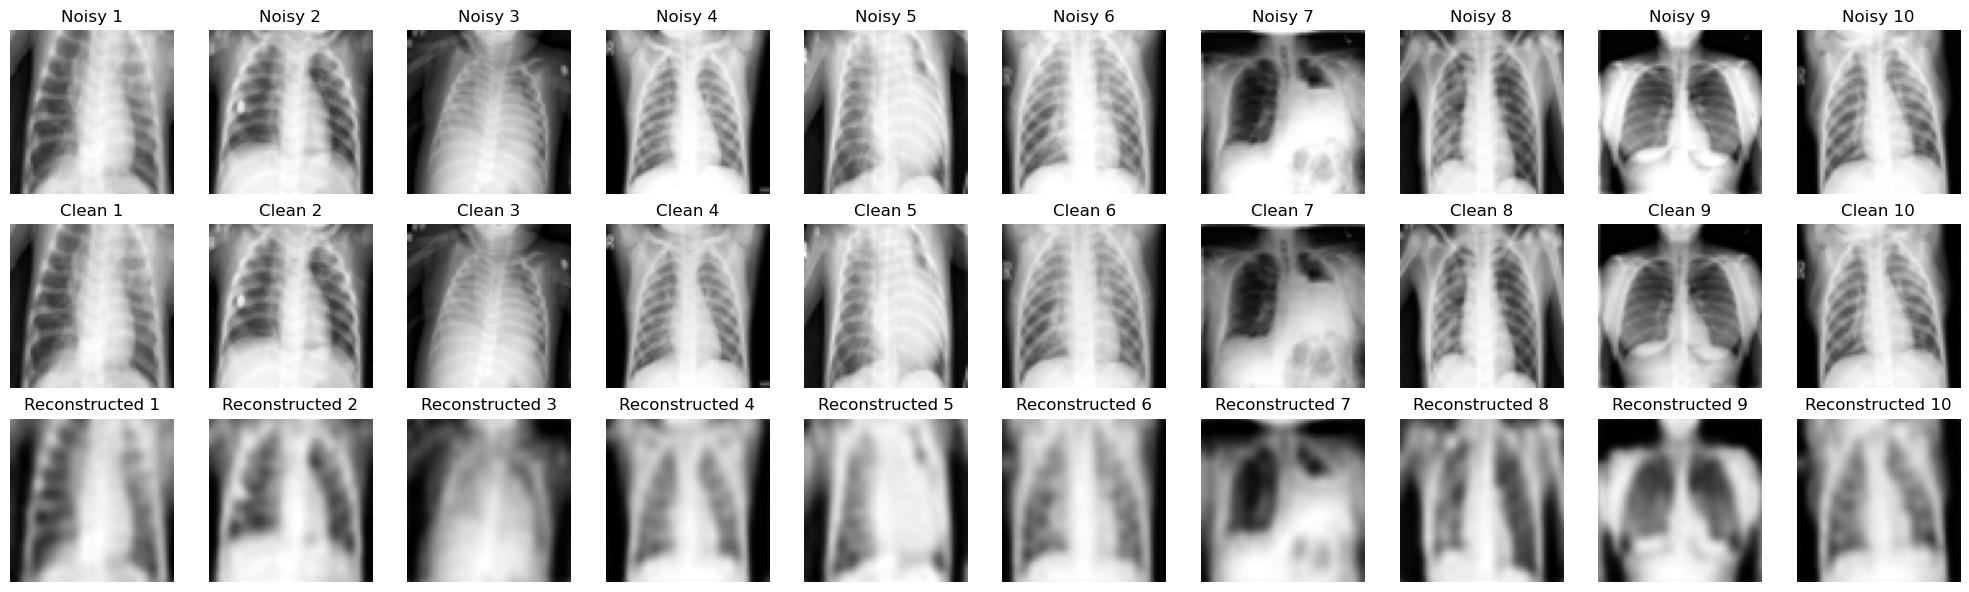

Average MSE: 0.11065761293659236, Average SSIM: 0.8361975223335524, Average PSNR: 26.179770268344818


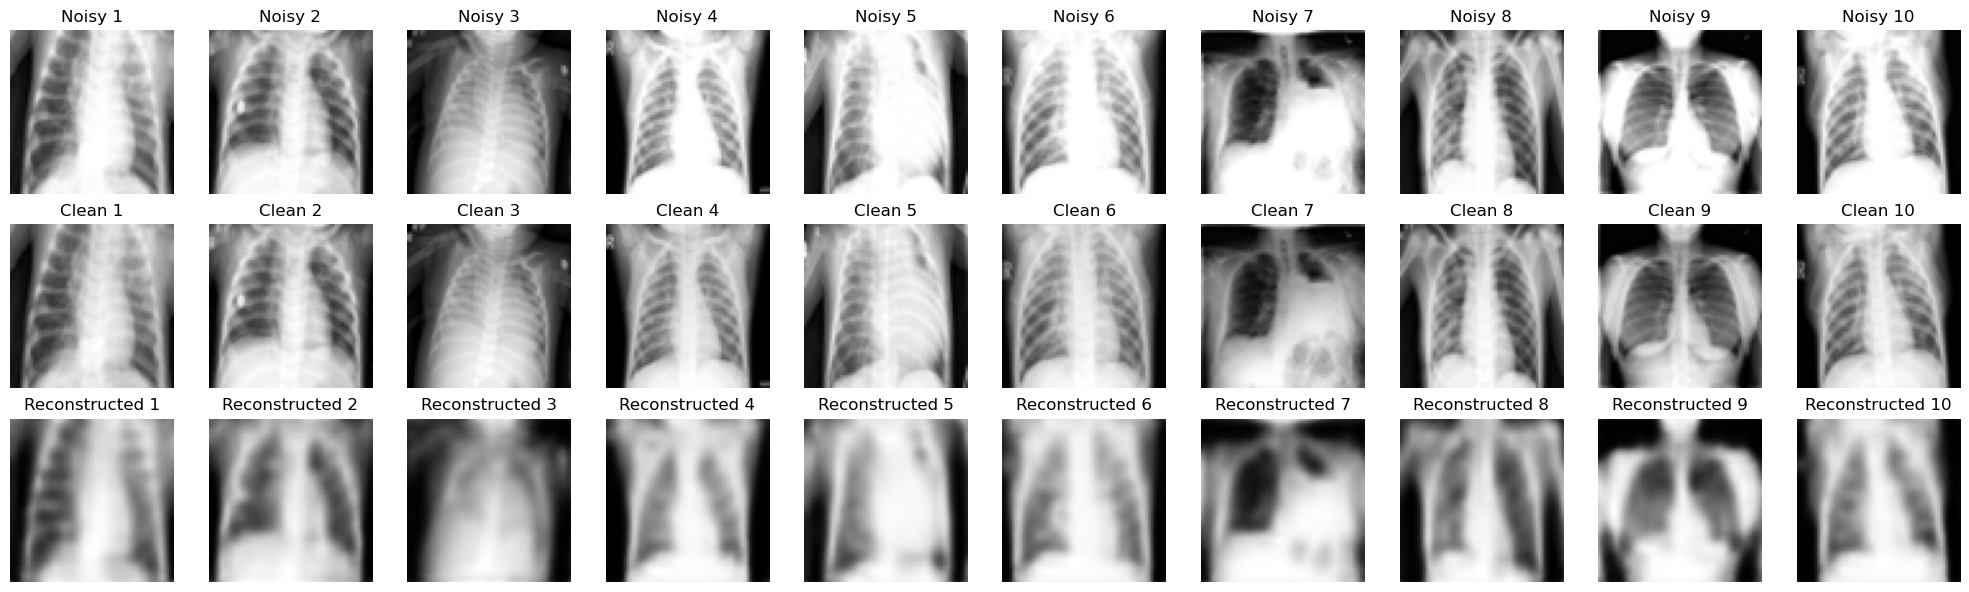

In [15]:
# Evaluate Models

evaluateModel(model25, testLoader25)
evaluateModel(model50, testLoader50)
evaluateModel(model75, testLoader75)

In [20]:
# Other filters

def applyMedianFilter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def applyMeanFilter(image, kernel_size=3):
    return cv2.blur(image, (kernel_size, kernel_size))

def applyBilateralFilter(image, diameter=15, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(image, diameter, sigmaColor, sigmaSpace)

def applyGaussianFilter(image, kernel_size=5, std=0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), std)

In [23]:
def evaluateModelWithFilter(dataLoader, filterFunc):
    totalMSE = 0.0
    totalSSIM = 0.0
    totalPSNR = 0.0
    
    with torch.no_grad():
        for noisyImgs, cleanImgs in dataLoader:
            noisyImgs = (noisyImgs.numpy() * 255).astype(np.uint8)
            cleanImgs = (cleanImgs.numpy() * 255).astype(np.uint8)
            
            for noisyImg, cleanImg in zip(noisyImgs, cleanImgs):
                noisyImg = np.squeeze(noisyImg)
                cleanImg = np.squeeze(cleanImg)
                
                filteredImg = filterFunc(noisyImg)
                
                filteredImgFloat = filteredImg.astype(np.float32) / 255
                cleanImgFloat = cleanImg.astype(np.float32) / 255
                
                mse = np.mean((filteredImgFloat - cleanImgFloat) ** 2)
                totalMSE += mse
                totalSSIM += SSIM(filteredImgFloat, cleanImgFloat, data_range=1.0)
                totalPSNR += PSNR(cleanImgFloat, filteredImgFloat, data_range=1.0)

    avgMSE = totalMSE / len(dataLoader.dataset)
    avgSSIM = totalSSIM / len(dataLoader.dataset)
    avgPSNR = totalPSNR / len(dataLoader.dataset)
    
    print(f'Filter: {filterFunc.__name__}, Average MSE: {avgMSE:.4f}, Average SSIM: {avgSSIM:.4f}, Average PSNR: {avgPSNR:.4f}')

In [24]:
evaluateModelWithFilter(testLoader25, applyMedianFilter)
evaluateModelWithFilter(testLoader25, applyMeanFilter)
evaluateModelWithFilter(testLoader25, applyBilateralFilter)
evaluateModelWithFilter(testLoader25, applyGaussianFilter)
evaluateModelWithFilter(testLoader50, applyMedianFilter)
evaluateModelWithFilter(testLoader50, applyMeanFilter)
evaluateModelWithFilter(testLoader50, applyBilateralFilter)
evaluateModelWithFilter(testLoader50, applyGaussianFilter)
evaluateModelWithFilter(testLoader75, applyMedianFilter)
evaluateModelWithFilter(testLoader75, applyMeanFilter)
evaluateModelWithFilter(testLoader75, applyBilateralFilter)
evaluateModelWithFilter(testLoader75, applyGaussianFilter)

Filter: applyMedianFilter, Average MSE: 0.0105, Average SSIM: 0.8610, Average PSNR: 19.7796
Filter: applyMeanFilter, Average MSE: 0.0102, Average SSIM: 0.9221, Average PSNR: 19.9147
Filter: applyBilateralFilter, Average MSE: 0.0132, Average SSIM: 0.6941, Average PSNR: 18.8059
Filter: applyGaussianFilter, Average MSE: 0.0104, Average SSIM: 0.9085, Average PSNR: 19.8441
Filter: applyMedianFilter, Average MSE: 0.0385, Average SSIM: 0.8109, Average PSNR: 14.1515
Filter: applyMeanFilter, Average MSE: 0.0382, Average SSIM: 0.8692, Average PSNR: 14.1790
Filter: applyBilateralFilter, Average MSE: 0.0414, Average SSIM: 0.6563, Average PSNR: 13.8296
Filter: applyGaussianFilter, Average MSE: 0.0384, Average SSIM: 0.8565, Average PSNR: 14.1584
Filter: applyMedianFilter, Average MSE: 0.0805, Average SSIM: 0.7306, Average PSNR: 10.9539
Filter: applyMeanFilter, Average MSE: 0.0800, Average SSIM: 0.7851, Average PSNR: 10.9814
Filter: applyBilateralFilter, Average MSE: 0.0837, Average SSIM: 0.5971, Ave

In [26]:
# Save models

torch.save(model25, "model25.pth")
torch.save(model50, "model50.pth")
torch.save(model75, "model75.pth")

## Evaluation Metrics

### MSE (Mean Squared Error)
| Method            | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|-------------------|-------------|-------------|-------------|
| Median Filter     | 0.0105      | 0.0385      | 0.0805      |
| Mean Filter       | 0.0102      | 0.0382      | 0.0800      |
| Bilateral Filter  | 0.0132      | 0.0414      | 0.0837      |
| Gaussian Filter   | 0.0104      | 0.0384      | 0.0802      |
| Autoencoder DAE   | 0.0730      | 0.0753      | 0.1107      |

### SSIM (Structural Similarity Index)
| Method            | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|-------------------|-------------|-------------|-------------|
| Median Filter     | 0.8610      | 0.8109      | 0.7306      |
| Mean Filter       | 0.9221      | 0.8692      | 0.7851      |
| Bilateral Filter  | 0.6941      | 0.6563      | 0.5971      |
| Gaussian Filter   | 0.9085      | 0.8565      | 0.7737      |
| Autoencoder DAE   | 0.8792      | 0.8759      | 0.8362      |

### PSNR (Peak Signal-to-Noise Ratio)
| Method            | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|-------------------|-------------|-------------|-------------|
| Median Filter     | 19.7796     | 14.1515     | 10.9539     |
| Mean Filter       | 19.9147     | 14.1790     | 10.9814     |
| Bilateral Filter  | 18.8059     | 13.8296     | 10.7860     |
| Gaussian Filter   | 19.8441     | 14.1584     | 10.9700     |
| Autoencoder DAE   | 27.8441     | 27.7082     | 26.1798     |

## Evaluating results

In [ ]:
# Evaluate your results against the test images by running the error term you used in submission 1 against each model compared with the 4 other classical methods. The result should be the average error value for each configuration.

**Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.**

The Poisson distribution stands out as the go-to model for simulating noise in medical images due to its close match to the random nature of photon detection, particularly in imaging methods like X-ray and PET scans. It excels in accurately representing situations with low photon counts, which are common in medical imaging, especially when using low radiation doses or capturing areas with minimal tissue density. Moreover, its ability to reflect changes in noise levels according to signal intensity mirrors the real-world behavior seen in medical images. The discrete nature of the Poisson distribution suits the whole number pixel values typical in medical imaging, and it maintains the clarity of edges better compared to the Gaussian distribution. Its solid theoretical grounding in photon counting processes also ensures that the simulated noise aligns well with the statistical properties of actual medical images.

**Which one performed the best? Why do you think this is the case?**

The Bilaterial filter had the best balance between noise reduction and detial preservation. We believe its because it manages to preserve the edge, does selective smoothing, and is very intuitive. It's also very robust.

In [14]:
# Submission 3: Relevance of Latent Space

In [15]:
# Encode Function

class NewCNNAutoencoder(CNNAutoencoder):
    def encode(self, x):
        z = self.encoder(x)
        return z

In [17]:
# Load model and get Z values

newModel = torch.load("model25.pth")
newModel.__class__ = NewCNNAutoencoder
newModel.eval()

zValues = []

for batch in trainLoader50:
    images = batch[0]  
    with torch.no_grad(): 
        z = newModel.encode(images)
        zValues.extend(z.cpu().numpy())

zValuesFlat = [z.flatten() for z in zValues]
zValuesDF = pd.DataFrame(zValuesFlat)

zValuesDF.to_csv('submission3.csv', index=False)

print("Z values dataset saved.")

Z values dataset saved.


In [ ]:
# Next step